In [2]:
import numpy
import scipy.special

#neural network class definition
class neuralNetwork :
    #initialise the neural network
    def __init__( self, inputnodes, hiddennodes, outputnodes, learningrate, wMa_wih, wMa_who) :
        # set number of nodes in each input, hidden, output layer
        self.inodes = inputnodes
        self.hnodes = hiddennodes
        self.onodes = outputnodes
        
        #link weight matrices, wih and who
        self.wih = wMa_wih.T # the shape of the wih is (hidden,input)
        self.who = wMa_who.T # the shape of the who is (output,hidden)
        
        #learning rate
        self.lr = learningrate
        
        #activation function is the sigmoid function
        self.activation_function = lambda x: scipy.special.expit(x)
        
        pass
    #train the neural network
    def train(self, inputs_list, targets_list) :
        #convert inputs list to 2d array
        inputs = numpy.array(inputs_list, ndmin = 2).T
        targets = numpy.array(targets_list, ndmin = 2).T
        
        #calculate signals into hidden layer
        hidden_inputs = numpy.dot(self.wih, inputs)
        #calculate the signals emerging from hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)
        
        #calculate signals into final output layer
        final_inputs = numpy.dot(self.who, hidden_outputs)
        #calculate the signals emerging from final output layer
        final_outputs = self.activation_function(final_inputs)
        #output layer error is (target - actual)
        output_errors = targets - final_outputs
        self.output_errors = targets - final_outputs
        #hidden layer error is the output_errors, split by weights, recombined at hidden nodes
        hidden_errors = numpy.dot(self.who.T, output_errors)
        
        #update the weights for the links between the hidden and output layers
        self.who += self.lr * numpy.dot((output_errors * final_outputs * (1.0 - final_outputs)), numpy.transpose(hidden_outputs))
        
        #update the weights for the links between the input and hidden layers
        self.wih += self.lr * numpy.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), numpy.transpose(inputs))
        
        pass
    #query the neural network
    def query(self, inputs_list) :
        #convert input list to 2d array
        inputs = numpy.array(inputs_list, ndmin = 2).T
        
        #calculate signals into hidden layer
        hidden_inputs = numpy.dot(self.wih, inputs)
        #calculate the signals emerging from hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)
        
        #calculate signals into final output layer
        final_inputs = numpy.dot(self.who, hidden_outputs)
        #calculate the signals emerging from final output layer
        final_outputs = self.activation_function(final_inputs)
        return final_outputs
        pass

In [3]:
#load weight matrix
wMa_pprel_file = open ("/Users/chix/neuralNetwork/wMa.pprel.txt",'r') #change this to the correct dir
wMa_pprel_list = wMa_pprel_file.readlines()
wMa_pprel_file.close()
wMa_pprel_col_geneID = wMa_pprel_list[0]
wMa_pprel_col_geneID = wMa_pprel_col_geneID[1:-1].split("\t") #remove "\n" and split by "\t"
for i in range(1,len(wMa_pprel_list)):
    record = wMa_pprel_list[i][:-1]
    wMa_pprel_list[i] = numpy.asfarray(record.split('\t'))
wMa_pprel_all = numpy.asarray(wMa_pprel_list[1:])
wMa_pprel_row_geneID = wMa_pprel_all[:,0].astype(int) #store the row gene ID, convert the float type to int
wMa_pprel_all = wMa_pprel_all[:,1:]

wMa_tf_file = open ("/Users/chix/neuralNetwork/wMa.tf.txt",'r') #change this to the correct dir
wMa_tf_list = wMa_tf_file.readlines()
wMa_tf_file.close()
wMa_tf_col_geneID = wMa_tf_list[0]
wMa_tf_col_geneID = wMa_tf_col_geneID[1:-1].split("\t") #remove "\n" and split by "\t"
for i in range(1,len(wMa_tf_list)):
    record = wMa_tf_list[i][:-1]
    wMa_tf_list[i] = numpy.asfarray(record.split('\t'))
wMa_tf_all = numpy.asarray(wMa_tf_list[1:])
wMa_tf_row_geneID = wMa_tf_all[:,0].astype(int) #store the row gene ID, convert the float type to int
wMa_tf_all = wMa_tf_all[:,1:]

In [4]:
#load scRNA-seq data
sc_data_file = open ("/Users/chix/neuralNetwork/Pellin2019/exprMa_mpp_rmDup_pellin_github.txt",'r')
sc_data_list = sc_data_file.readlines()
sc_data_file.close()
cell_barcode = sc_data_list[0].split('\t')
for i in range(1,len(sc_data_list)):
    record=str(sc_data_list[i][:-1])
    #tmp_data=record.split('\t')
    sc_data_list[i] = numpy.asarray(record.split('\t'))
sc_data=numpy.asarray(sc_data_list[1:]) #all the expr data
nCell_positive = numpy.array([])
for i in range(sc_data.shape[0]):
    index_positive = [j for j in range(3,len(sc_data[i,:])) if float(sc_data[i,j]) > 0]
    nCell_positive = numpy.append(nCell_positive,len(index_positive))
index_positive = [j for j in range(len(nCell_positive)) if float(nCell_positive[j]) > 3]
sc_data = sc_data[index_positive,:]

In [5]:
sc_data.shape,cell_barcode[0:4]

((8928, 217),
 ['HGNC.symbol',
  'NCBI.gene..formerly.Entrezgene..ID',
  'GGGAGATG.ATCCCACG',
  'AAGAAGGT.GTTCAACT'])

In [6]:
##select the cells according to the barcode annotation file for a specific cell type
#sc_data_sub = sc_data[:,numpy.isin(cell_barcodes, barcode)]
#print(sc_data_sub.shape, cell_type)
sc_data_sub = numpy.array(sc_data)
test_cells = sc_data_sub.shape[1]/3
if(test_cells > 1):
    test_cells = int(test_cells)
    print("Number of testing cells is",test_cells)
else:
    print("Not enough cells for test of overfit."+"\n")

Number of testing cells is 72


In [7]:
sc_data_sub.shape

(8928, 217)

In [8]:
#create test dataset
##a fraction (1/10) of the expressed genes in each cell will be masked (to be zero). 
##The real values of these masked genes will be stored in another matrix, to compare with imputed values
import random
test_dataset = numpy.array(sc_data_sub.T[2:,:])
masked_test_dataset = numpy.array(test_dataset)
ori_values = numpy.zeros((test_dataset.shape[0],test_dataset.shape[1]))
for i in (range(test_dataset.shape[0])): #each row is a cell
    index_positive = [j for j in range(len(test_dataset[i,:])) if float(test_dataset[i,j]) > 0]
    index_masked = random.sample(index_positive,int(len(index_positive)/10))
    #index_left = numpy.array(index_positive)[(numpy.isin(index_positive,index_masked)==False).nonzero()[0]]
    masked_test_dataset[i,index_masked] = 0 #converting the masked genes' values to 0
    ori_values[i,index_masked] = numpy.array(test_dataset[i,index_masked]) #storing the original values of the genes
#masking sc_data_sub
print(sc_data_sub.shape)
sc_data_sub_bk = numpy.array(sc_data_sub)
sc_data_sub[:,2:] = numpy.array(masked_test_dataset.T)

(8928, 217)


In [9]:
#train the NN
updated_genes = numpy.array([])
arr_squared_all = numpy.array([])
arr_root_all =numpy.array([])
for j in range(10):
    for i in range(test_cells,sc_data_sub.shape[1]-2):
    #for i in range(0,2):
        cell_ind=i+1 #the i th cell
        index = [k for k in range(len(sc_data_sub.T[cell_ind+1,:])) if float(sc_data_sub.T[cell_ind+1,k]) > 0] #index of the gene expr >0 
        expr=numpy.array(sc_data_sub.T[cell_ind+1,:])[index] #gene expr
        geneNames = numpy.array(sc_data_sub.T[1,:])[index] #gene names
        #intersect input and weight matrix
        ##for inputs and wih
        xy, xy_ind1, xy_ind2 = numpy.intersect1d(geneNames, wMa_pprel_row_geneID, return_indices = True)
        expr_sub = expr[xy_ind1] #intersect will also sort the indices, so that the genes of expr_sub and wMa_pprel_sub will match
        wMa_pprel_sub = wMa_pprel_all[xy_ind2,] #!the wih of this cell
        wMa_pprel_row_geneID_sub = wMa_pprel_row_geneID[xy_ind2]#the gene id of the wih of a single cell
        ##need to store the rest of the weight matrix
        rest_list = list(set(wMa_pprel_row_geneID.astype(int)) - set(xy.astype(int)))
        xy,rest_ind1,xy_ind2 = numpy.intersect1d(wMa_pprel_row_geneID,rest_list,return_indices = True)
        wMa_pprel_rest = wMa_pprel_all[rest_ind1,] #!the rest of the wih, which will be concatencated to the updated wMa_pprel_sub
        wMa_pprel_row_geneID_rest = wMa_pprel_row_geneID[rest_ind1,] #the row gene id of the rest of the wih
        wMa_pprel_row_geneID_new = numpy.concatenate((wMa_pprel_row_geneID_sub,wMa_pprel_row_geneID_rest),axis = None) #!the row gene id of the new wih
        inputs = expr_sub #!the input of the training data
        ##for who and targets
        xy, xy_ind1, xy_ind2 = numpy.intersect1d(geneNames, wMa_tf_col_geneID, return_indices = True)
        expr_sub = expr[xy_ind1]
        wMa_tf_sub = wMa_tf_all[:,xy_ind2] #!the who of this cell
        wMa_tf_col_geneID_sub = numpy.asarray(wMa_tf_col_geneID)[xy_ind2] #the gene id of the who of a single cell
        updated_genes = numpy.union1d(updated_genes, wMa_tf_col_geneID_sub) #the union of the genes used as targets when querying the network
        ##need to store the rest of the weight matrix
        wMa_tf_col_geneID = numpy.asarray(wMa_tf_col_geneID)
        rest_list = list(set(wMa_tf_col_geneID.astype(int)) - set(xy.astype(int)))
        xy,rest_ind1,xy_ind2 = numpy.intersect1d(wMa_tf_col_geneID,rest_list,return_indices = True)
        wMa_tf_rest = wMa_tf_all[:,rest_ind1] #!the rest of the who, which will be concatencated to the updated wMa_tf_sub
        wMa_tf_col_geneID_rest = wMa_tf_col_geneID[rest_ind1] #! the column gene id of the rest of who
        wMa_tf_col_geneID_new = numpy.concatenate((wMa_tf_col_geneID_sub,wMa_tf_col_geneID_rest),axis = None) #!the col gene id of the new who
        targets = expr_sub #!the target of the training data
        inputs = numpy.asfarray(inputs)
        targets = numpy.asfarray(targets)
        #number of input, hidden and output nodes
        input_nodes = wMa_pprel_sub.shape[0]
        hidden_nodes = wMa_pprel_sub.shape[1]
        output_nodes = wMa_tf_sub.shape[1]
        #learning rate
        learning_rate = 0.02
        #create instance of neural network
        n = neuralNetwork(input_nodes,hidden_nodes,output_nodes,learning_rate, wMa_pprel_sub, wMa_tf_sub)
        scaleFac= numpy.max(targets) # the training data set is also scaled by this scale factor
        targets = targets/scaleFac
        inputs = inputs/scaleFac
        #train the neural network
        epochs = 2
        errorList=list() #this is used to check the changes of the errors
        for e in range(epochs):
            n.train(inputs,targets)
            errorList.append(n.output_errors)
        #after training the nn, update the original total weight matrix
        tmp_wMa_pprel=numpy.vstack((n.wih.T,wMa_pprel_rest))
        tmp_wMa_tf = numpy.hstack((n.who.T,wMa_tf_rest))
        wMa_pprel_all = tmp_wMa_pprel
        wMa_pprel_row_geneID = wMa_pprel_row_geneID_new #update the gene id of the new matrix, since the order of the genes has been changed
        wMa_tf_all = tmp_wMa_tf
        wMa_tf_col_geneID = wMa_tf_col_geneID_new #similar reason to pprel
        #print("Done training network for cell", cell_ind, "round",j+1)
    #begin to calculate errors for each cell
    print("Calculating error estimations for round",j+1)
    arr_squared=numpy.array([])
    arr_root=numpy.array([])
    #for i in range(sc_data_sub.shape[1]-2):
    for i in range(test_cells):
        cell_ind=i+1
        index = [k for k in range(len(sc_data_sub.T[cell_ind+1,:])) if float(sc_data_sub.T[cell_ind+1,k]) > 0] #index of the gene expr >0 
        expr=numpy.array(sc_data_sub.T[cell_ind+1,:])[index] #gene expr
        geneNames = numpy.array(sc_data_sub.T[1,:])[index] #gene names
        #intersect input and weight matrix
        ##for inputs and wih
        xy, xy_ind1, xy_ind2 = numpy.intersect1d(geneNames, wMa_pprel_row_geneID, return_indices = True)
        expr_sub = expr[xy_ind1]
        wMa_pprel_sub = wMa_pprel_all[xy_ind2,] #!the wih of this cell
        inputs = expr_sub #!the input of the training data
        ##for who and targets, the weight matrix is wMa_tf_updated
        xy, xy_ind1, xy_ind2 = numpy.intersect1d(updated_genes, wMa_tf_col_geneID, return_indices = True)
        #expr_sub = expr[xy_ind1]
        wMa_tf_updated = wMa_tf_all[:,xy_ind2] #!the who of this cell
        wMa_tf_col_geneID_sub = wMa_tf_col_geneID[xy_ind2] #the gene id of the who of a single cell
        inputs = numpy.asfarray(inputs)
        #targets = numpy.asfarray(targets)
        #number of input, hidden and output nodes
        input_nodes = wMa_pprel_sub.shape[0]
        hidden_nodes = wMa_pprel_sub.shape[1]
        output_nodes2 = wMa_tf_updated.shape[1]
        #learning rate
        learning_rate = 0.2 #this will not be used since the newly created instance will only be queried but not trained
        #the weight matrix of who has to be created by taking the "updated_genes" into account
        
        #create instance of neural network. We don't need to train this network; we will only use this instance to query/imputate
        n = neuralNetwork(input_nodes,hidden_nodes,output_nodes2,learning_rate, wMa_pprel_sub, wMa_tf_updated)
        scaleFac= numpy.max(targets) # the training data set is also scaled by this scale factor
        #targets = targets/scaleFac
        inputs = inputs/scaleFac
        
        #query the neural network
        output_query = n.query(inputs)
        xy, xy_ind1, xy_ind2 = numpy.intersect1d(geneNames, wMa_tf_col_geneID_sub, return_indices = True)
        targets = numpy.asfarray(expr[xy_ind1])
        scaleFac= numpy.max(targets)
        targets = targets/scaleFac
        targets = numpy.array(targets, ndmin = 2).T
        output_targets = numpy.array(output_query[xy_ind2], ndmin = 2)
        #print(len(targets),len(output_targets),type(targets), type(output_query))
        #df_perc = (output_targets-targets)/targets
        df_subtr = (output_targets - targets)*scaleFac
        gene_num = len(df_subtr)
        df_squared = numpy.sum(numpy.power(df_subtr,2))/numpy.power(gene_num, 1)
        df_root = numpy.sum(numpy.power(abs(df_subtr), 0.5))/numpy.power(gene_num, 1) 
        arr_squared = numpy.append(arr_squared,df_squared)
        arr_root = numpy.append(arr_root,df_root)
    if(len(arr_root_all) == 0):#if they are void
        arr_squared_all = arr_squared
        arr_root_all = arr_root
    else:
        arr_squared_all = numpy.vstack((arr_squared_all,arr_squared))
        arr_root_all = numpy.vstack((arr_root_all,arr_root))

Calculating error estimations for round 1
Calculating error estimations for round 2
Calculating error estimations for round 3
Calculating error estimations for round 4
Calculating error estimations for round 5
Calculating error estimations for round 6
Calculating error estimations for round 7
Calculating error estimations for round 8
Calculating error estimations for round 9
Calculating error estimations for round 10


<function matplotlib.pyplot.show(close=None, block=None)>

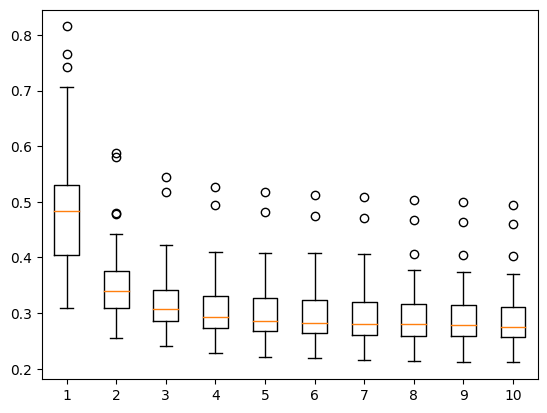

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.boxplot(arr_squared_all.T)
plt.show


In [11]:
scaleFac

6.584963

In [12]:
#for imputation using the matched cell type and regulatory networks
#imputation and check the prediction by the errors of target-output
##prepare the input and target data
#arr_squared=numpy.array([])
#arr_root=numpy.array([])
imputation_result = numpy.array([])
arr_squared = numpy.array([])
arr_root = numpy.array([])
#array_result = sc_data_sub[:,2:] #copy from the original data selected for this cell type
for i in range(sc_data_sub.shape[1]-2):
    cell_ind=i+1
    index = [i for i in range(len(sc_data_sub.T[cell_ind+1,:])) if float(sc_data_sub.T[cell_ind+1,i]) > 0] #index of the gene expr >0 
    expr=numpy.array(sc_data_sub.T[cell_ind+1,:])[index] #gene expr
    geneNames = numpy.array(sc_data_sub.T[1,:])[index] #gene names
    #intersect input and weight matrix
    ##for inputs and wih
    xy, xy_ind1, xy_ind2 = numpy.intersect1d(geneNames, wMa_pprel_row_geneID, return_indices = True)
    expr_sub = expr[xy_ind1]
    wMa_pprel_sub = wMa_pprel_all[xy_ind2,] #!the wih of this cell
    inputs = expr_sub #!the input of the training data
    ##for who and targets, the weight matrix is wMa_tf_updated
    xy, xy_ind1, xy_ind2 = numpy.intersect1d(updated_genes, wMa_tf_col_geneID, return_indices = True)
    #expr_sub = expr[xy_ind1]
    wMa_tf_updated = wMa_tf_all[:,xy_ind2] #!the who of this cell
    wMa_tf_col_geneID_sub = wMa_tf_col_geneID[xy_ind2] #the gene id of the who of a single cell
    inputs = numpy.asfarray(inputs)
    #targets = numpy.asfarray(targets)
    #number of input, hidden and output nodes
    input_nodes = wMa_pprel_sub.shape[0]
    hidden_nodes = wMa_pprel_sub.shape[1]
    output_nodes2 = wMa_tf_updated.shape[1]
    #learning rate
    learning_rate = 0.2 #this will not be used since the newly created instance will only be queried but not trained
    #the weight matrix of who has to be created by taking the "updated_genes" into account
    
    #create instance of neural network. We don't need to train this network; we will only use this instance to query/imputate
    n = neuralNetwork(input_nodes,hidden_nodes,output_nodes2,learning_rate, wMa_pprel_sub, wMa_tf_updated)
    scaleFac= numpy.max(numpy.asfarray(expr)) # the training data set is also scaled by this scale factor
    #targets = targets/scaleFac
    inputs = inputs/scaleFac
    
    #query the neural network
    output_query = n.query(inputs)
    #compute errors
    xy, xy_ind1, xy_ind2 = numpy.intersect1d(geneNames, wMa_tf_col_geneID_sub, return_indices = True)
    targets = numpy.asfarray(expr[xy_ind1])
    #scaleFac= numpy.max(targets)
    targets = targets/scaleFac
    targets = numpy.array(targets, ndmin = 2).T
    output_targets = numpy.array(output_query[xy_ind2], ndmin = 2)
    df_subtr = output_targets - targets
    gene_num = len(df_subtr)
    df_squared = numpy.sum(numpy.power(df_subtr,2))/numpy.power(gene_num, 0.5)
    df_root = numpy.sum(numpy.power(df_squared, 0.25))/numpy.power(gene_num, 0.5) # first square then **0.25, so no need to take the abs()
    arr_squared = numpy.append(arr_squared,df_squared)
    arr_root = numpy.append(arr_root,df_root)
    if(len(imputation_result) == 0):
        imputation_result = (output_query * scaleFac).T
    else:
        imputation_result = numpy.vstack((imputation_result, (output_query * scaleFac).T))
    

In [13]:
cell_type = "MPP_BM_Pellin_github"

In [14]:
cell_type

'MPP_BM_Pellin_github'

In [15]:
#output imputation result
#celltype_barcodes = numpy.array(cell_barcodes)[numpy.isin(cell_barcodes, barcode)][2:]
array_result = numpy.array(sc_data_sub[:,:])
xy, xy_ind1, xy_ind2 = numpy.intersect1d(sc_data_sub[:,1], wMa_tf_col_geneID_sub, return_indices = True)
for i in range(2,array_result.shape[1]):
    array_result[xy_ind1,i]=imputation_result.T[xy_ind2,i-2]
##each row is a gene, and the gene id are stored in wMa_tf_col_geneID_sub
##each column is a cell, and the cell barcodes are stored in cell_barcode
file = open("imputedExpr_"+cell_type+".txt","w")
file.writelines("\t".join(map(str,cell_barcode)))
for i in array_result:
    joined_line = "\t".join(map(str,i))
    file.writelines(joined_line+"\n")
file.close()